In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.spatial.distance import cdist
import sys
import os
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload

"""WARNING! """
import warnings
warnings.filterwarnings("ignore")


# local imports 
import graph as gr
import utils as ut

In [2]:
# load the data

In [3]:
key = "HFD14"

dirpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/graph_data/"
coordpath = f"{dirpath}coordinates.pq"
distpath = f"{dirpath}/distances/{key}_euclidean_distances.pq"
cardpath = f"{dirpath}/global_card_outputs.pq"


cdf = pd.read_parquet(coordpath)
cdf = cdf[cdf['key'] == key].reset_index(drop=True)
print(f"{cdf.shape=}")
print(cdf.head())

D = pd.read_parquet(distpath)
D = D.drop(columns='key')
print(f"{D.shape=}")
print(D.head())

df = pd.read_parquet(cardpath)
print(f"{df.shape=}")
print(df.head())

cdf.shape=(1994, 5)
                     spotId    key nodeId            x            y
0  AAACATTTCCCGGATT.1_HFD14  HFD14    3_1  1139.783401  1365.804581
1  AAACCGGGTAGGTACC.1_HFD14  HFD14    3_2   468.056902  1045.415505
2  AAACCGTTCGTCCAGG.1_HFD14  HFD14    3_3   604.524374  1214.452428
3  AAACCTAAGCAGCCGG.1_HFD14  HFD14    3_4  1003.708924  1433.743571
4  AAACCTCATGAAGTTG.1_HFD14  HFD14    3_5   380.369919   960.970730
D.shape=(1987021, 3)
  node1 node2           d
0   3_1   3_2  744.221505
1   3_1   3_3  556.246078
2   3_1   3_4  152.091978
3   3_1   3_5  860.580782
4   3_1   3_6   89.387385
df.shape=(7424, 18)
                    spotId            x            y   key   B cells   
0  AAACAAGTATCTCCCA.1_HFD8  1244.795278  1189.669724  HFD8  0.077635  \
1  AAACACCAATAACTGC.1_HFD8   405.548324  1349.579809  HFD8  0.076987   
2  AAACAGCTTTCAGAAG.1_HFD8   303.880251  1068.178931  HFD8  0.079216   
3  AAACAGGGTCTATATT.1_HFD8   344.496391  1138.478061  HFD8  0.037682   
4  AAACAGTGTTCC

# Build random neighborhoods

In [4]:
cellTypes = [
    'B cells',
    'Dendritic cells',
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Monocytes',
    'NK cells',
    'Stromal cells',
    'T cells'
]

In [5]:
reload(gr)

n = len(cdf)
# n = 250
r = 45

def feature_similarity(x, y, metric='correlation', as_distance=False):
    """A function to compute feature distances """
    print(f"{x.shape=}")
    print(f"{y.shape=}")
    res = []
    for i, tup in enumerate(zip(x, y)):
        d = scipy.spatial.distance.cdist(tup[0].reshape(1, -1), 
                                         tup[1].reshape(1, -1),
                                         metric=metric)

        if not as_distance:
            d = 1 / np.exp(d) # convert to similarity
            
        res.append(d[0][0])
    return res

nbrhd = gr.get_neighborhood(cdf, 
                            center=True, 
                            n=n, 
                            metric='minkowski')

# subset the edges and coords of the spaitial data
coords = cdf[cdf['nodeId'].isin(nbrhd)].reset_index()
edges = D[(D['node1'].isin(nbrhd)) & (D['node2'].isin(nbrhd))].reset_index(drop=True)    
edges = edges[edges['d'] < r]

card = df[df['nodeId'].isin(nbrhd)]
card = card.set_index('nodeId')

idf = card.loc[edges['node1'], cellTypes]
jdf = card.loc[edges['node2'], cellTypes]

edges['node_similarity'] = feature_similarity(idf.to_numpy(), jdf.to_numpy())
edges['node_similarity'] = edges['node_similarity'].fillna(0)
edges.head()

x.shape=(16816, 11)
y.shape=(16816, 11)


,node1,node2,d,node_similarity
112,3_1,3_114,33.846720,0.477071
133,3_1,3_135,39.056956,0.900801
154,3_1,3_156,33.726834,0.525706
369,3_1,3_371,19.522654,0.565650
659,3_1,3_661,39.020732,0.365340


In [6]:
# # plot the landscape
# pdf = edges.copy()

# pdf.head()

t=18.473961557558457


(180.9535100088, 1465.1055448712, 1759.968620848, 347.662920592)

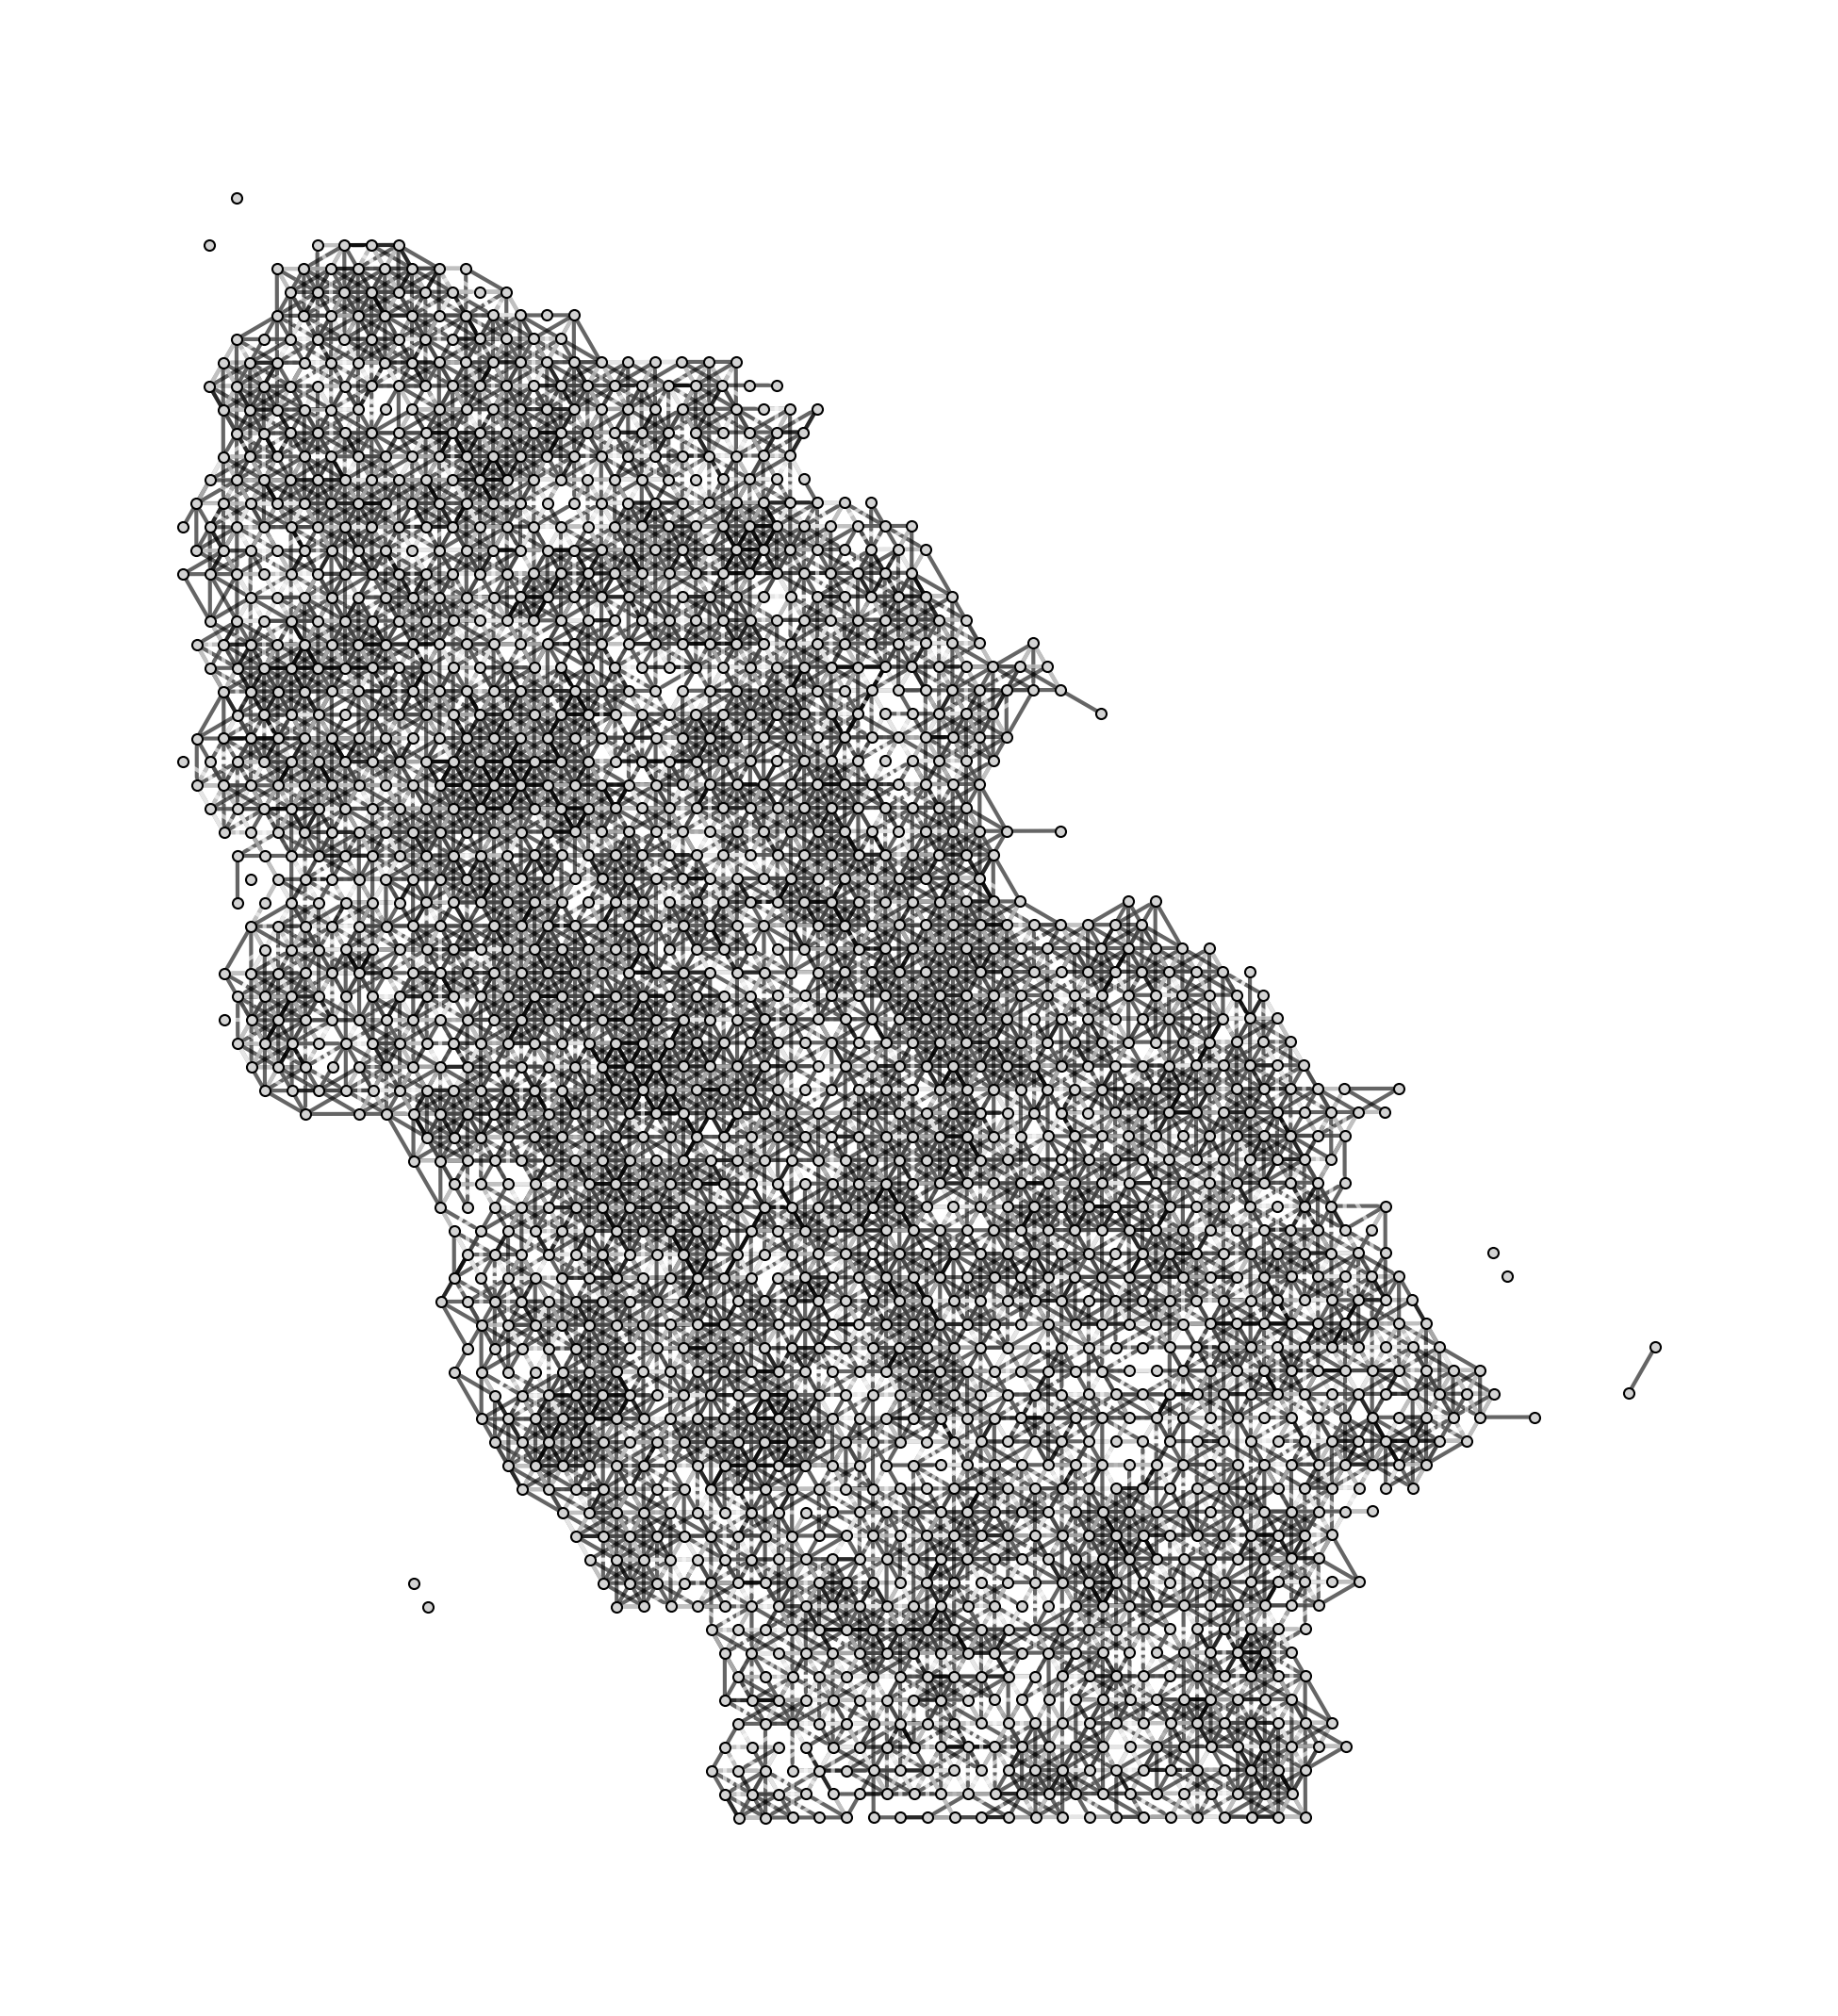

In [9]:
# plot the landscape
pdf = edges.copy()
pdf['c'] = pdf['node_similarity'] * pdf['d']

color_weight = 'c'

G = gr.build_graph(pdf, coords)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "none"
plt.rcParams['figure.figsize'] = 9, 9

# plotting params
lut = 5
# cmap = plt.cm.get_cmap('RdYlGn', lut=lut)
cmap = plt.cm.get_cmap('binary', lut=lut)
fig, ax = plt.subplots()

# network plots
nx.draw_networkx_nodes(G,
                       pos=G.pos,
                       node_size=7,
                       # node_color=colors,
                       node_color='lightgrey',
                       # cmap=cmap,
                       # alpha=0.75,
                       edgecolors='k',
                       linewidths=0.5,
                       ax=ax)

eweights = np.array([e[color_weight] for node1, node2, e in G.edges(data=True)]) 
eq = 0.5
t = np.quantile(eweights, eq)
print(f"{t=}")
eweights = np.where(eweights > t, 1, 0)



nx.draw_networkx_edges(G,
                       pos=G.pos,
                       width=1,
                       # edge_color='k',
                       edge_color=eweights,
                       edge_cmap=cmap, 
                       # edge_vmin=0, 
                       # edge_vmax=1,
                       alpha=0.6,
                       ax=ax)   


ax.set_aspect('equal')
ax.invert_yaxis()
ax.axis(False)

In [8]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# metrics

pdf = edges.copy()
pdf['c'] = pdf['node_similarity'] * pdf['d']
G = gr.build_graph(pdf, coords)

# A = nx.adjacency_matrix(G, weight='c')
# A = A.todense()
# print(f"{A.shape=}")

# eq = 0.25
# t = np.quantile(A, eq)
# print(f"{t=}")
# A = np.where(A > t, 1, 0)

# """Resistance:"""
# L = scipy.sparse.csgraph.laplacian(A, normed=True)
# print(f"{L.shape=}")
# ev, ew = np.linalg.eigh(L)
# print(ev[:10])




In [ ]:
# ?nx.adjacency_matrix

In [ ]:
ut.makeColorbar('RdYlGn', 0.3, 2.5, "Weighted Correlation", 'vertical', ['Low', 'High'])

In [ ]:
break

In [ ]:
n = 3
X = np.random.random((n, n))
X = np.dot(X, X.T)
X = X / X.max()
X = X - np.diag(np.diag(X))
# X = X * 30

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "none"
plt.rcParams['figure.figsize'] = 15, 5

fig, axs = plt.subplots(1, 3)

sns.heatmap(X, 
            annot=True,
            fmt=".1f",
            cbar=False,
            square=True,
            cmap='RdYlGn_r',
            ax=axs[0])

axs[0].set_title("X")

Y = np.random.random((n, n))
Y = Y @ Y.T
Y = Y / Y.max()

Y = Y - np.diag(np.diag(Y))

sns.heatmap(Y, 
            annot=True,
            fmt=".1f",
            cbar=False,
            square=True,
            cmap='RdYlGn',
            ax=axs[1],
            )
axs[1].set_title("Y")

A = np.multiply(X, Y)
sns.heatmap(A, 
            annot=True,
            fmt=".1f",
            cbar=False,
            square=True,
            cmap='RdYlGn_r',
            ax=axs[2],
            )

axs[2].set_title("A")

In [ ]:
0.6 * 0.2

In [ ]:
break

In [ ]:
ut.makeColorbar(cmap, 0.3, 3, 'Correlation', 'vertical', ['Low', 'High'])

In [ ]:
break

In [ ]:
df.columns

In [ ]:
# A = nx.adjacency_matrix(G, weight='innate_innate')
# A = A.todense()
# L = scipy.sparse.csgraph.laplacian(A, normed=True)

# fig, axs = plt.subplots(1, 2)
# axs = axs.ravel()

# axs[0].matshow(A)
# axs[1].matshow(L)

# axs[0].set_xticks([])
# axs[0].set_yticks([])
# axs[1].set_xticks([])
# axs[1].set_yticks([])

# plt.tight_layout()